<a href="https://colab.research.google.com/github/aleksejalex/DetermiTime/blob/main/NAEX_Gaj_determinants_VER6_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "DetermiTime" - version 6
(determinant + time)

*by Aleksej Gaj*

**Experiment performed:** time needed to compute a determinant of a matrix is of interest.
Variables considered - see table below.

Data generation was performed in Python 3.9. \
Analysis (this notebook) was done in Python 3.12.

This notebook presents **factorial analysis** of the experiment.




## Data generation

Dataset was generated via python program (in repo) run on server. Resulting datasets were saved and merged together. This notebook imports already merged dataset.

### Algorithm of generating data

Aim of this experiment is to determine which properties of matrix affect amount of time needed for computation of determinant of the matrix.

Data were generated using `measure_script.py`, where are simply several for cycles inside each other (which ensures running det(mtx) for every combination of parameters mentioned above).
Besides named parameters also many other technical details are set (CPU type, OS, kernel version, current time, etc.)

Resulting dataframe is saved as csv file, which is loaded in this notebook.

### Random order of experiments

The design itself was not randomised in every variable:
 - to eliminate influence of the order in which measurements were performed, Python kernel **was given a brake after every sequence of measurements** (time.sleep(5)). Also as one of variables considered `sleep`was taken, which was 0sek or 0.3sek between every computation.
 - Set of experiments was performed on **a server where cores were explicitly allocated for each run** (ie. `num_of_cores` is randomized by design).
 - Server had **plenty of RAM available** for Python kernel, so the dependency on that was eliminated too (for instance cases like: big matrix can allocate more RAM and run faster then smaller matrix).
 - **wear of the server** can be considered as not significant due to very short computing time (~4 hours).

### Theoretical background:

 - method from LAPACK used by `scipy.linalg.det()` *(USED HERE)* >>
https://netlib.org/lapack/explore-html/db/d04/group__getrf.html

 - method from LAPACK used by `numpy.linalg.det()` *(NOT TESTED HERE)* >>
https://netlib.org/lapack/explore-html/db/d04/group__getrf_gaea332d65e208d833716b405ea2a1ab69.html \
Had problems with higher dimensions and problems with almost-singular matrices.

## Variables:

| var name       	| values                               	| type    	| center points? 	| comment           	|
|----------------	|--------------------------------------	|---------	|----------------	|-------------------	|
| `dim`          	| high = 3000, low = 1000              	| numeric 	| Y              	|                   	|
| `triangle`     	| True = triangular, False = unchanged 	| factor  	| N              	|                   	|
| `type_of_elem` 	| `True` = INT, `False` = FLOAT)       	| factor  	| N              	|                   	|
| `n_loops`      	| high = 1000, low = 10                	| numeric 	| Y              	|                   	|
| `sleep`        	| high = 0.5 sek, low = 0 sek          	| numeric 	| Y              	|                   	|
| `num_of_cores` 	| high = 8, low = 2                    	| numeric 	| Y              	|                   	|
| `exec_time`    	| -                                    	| FLOAT   	| -              	| response variable 	|

## imports

In [126]:
!mkdir img

mkdir: cannot create directory ‘img’: File exists


In [127]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import pandas as pd

In [128]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Loading and preparing dataset (without center points)

**Preprocessing pipeline:**

> `import df --> factorize (*) --> categorize (**) --> randomise order`

`(*)` = assign 1 to high levels and -1 to low levels (for both numeric and categorical variables). Reason: to avoid problems with large condition number of $\mathbf{X}^{T}\mathbf{X}$. \
For convenient inference (prediction) scaling factor will be computed later on.

`(**)` = means change of type of variable (some variables should be taken as numeric (ie. type int or float), some have only discrete levels and should be taken as categorical). \
Difference: to compute regression coeficient of numeric variable, one parameter needs to be estimated, but for categorical variable with $n$ possible values (levels) $n-1$ parameters are estimated.

In [129]:
file_path = 'https://raw.githubusercontent.com/aleksejalex/DetermiTime/main/df_raw_emu.csv'
#file_path_to_pickle = 'df_raw.pkl'

# Load the DataFrame
try:
    #df_raw = pd.read_pickle(file_path_to_pickle)
    df_raw = pd.read_csv(file_path, delimiter=';')
    #df_cp = pd.read_csv(file_path_with_centerpoints, delimiter=';')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print(f"File not found at path: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame loaded successfully.


In [130]:
df_raw.head(6) # 64 to see all

,exec_time,dim,type_of_elem,n_loops,sleep,triangle,num_of_cores
0,0.018810,1000,True,10,0.0,False,2
1,0.026176,1000,True,10,0.5,False,2
2,0.015455,1000,True,1000,0.0,False,2
3,0.020316,1000,True,1000,0.5,False,2
4,0.015019,1000,False,10,0.0,False,2
5,0.020646,1000,False,10,0.5,False,2


In [131]:
df_raw.describe(include='all')

,exec_time,dim,type_of_elem,n_loops,sleep,triangle,num_of_cores
count,64.000000,64.000000,64,64.000000,64.000000,64,64.000000
unique,NaN,NaN,2,NaN,NaN,2,NaN
top,NaN,NaN,True,NaN,NaN,False,NaN
freq,NaN,NaN,32,NaN,NaN,32,NaN
mean,0.082607,2000.000000,NaN,505.000000,0.250000,NaN,5.000000
std,0.078344,1007.905261,NaN,498.913104,0.251976,NaN,3.023716
min,0.007944,1000.000000,NaN,10.000000,0.000000,NaN,2.000000
25%,0.015361,1000.000000,NaN,10.000000,0.000000,NaN,2.000000
50%,0.057970,2000.000000,NaN,505.000000,0.250000,NaN,5.000000
75%,0.128916,3000.000000,NaN,1000.000000,0.500000,NaN,8.000000


In [132]:
df = df_raw.copy()

In [133]:
print(df.dtypes)

exec_time       float64
dim               int64
type_of_elem       bool
n_loops           int64
sleep           float64
triangle           bool
num_of_cores      int64
dtype: object


In [134]:
#"""  SIMPLE ONE HOT ENCODING  """
#df = pd.get_dummies(df, columns=['type_of_elem', 'triangle', 'n_loops', 'sleep'])

### factorize: move to [-1, 1] values

| var. name      	| real values      	| factorized values 	|
|----------------	|------------------	|-------------------	|
| `dim`          	| 1000             	| -1                	|
|                	| 3000             	| 1                 	|
| `type_of_elem` 	| True(float)      	| -1                	|
|                	| False(int)       	| 1                 	|
| `n_loops`      	| 10               	| -1                	|
|                	| 1000             	| 1                 	|
| `sleep`        	| 0                	| -1                	|
|                	| 0.5              	| 1                 	|
| `triangle`     	| False(regular)   	| -1                	|
|                	| True(triangular) 	| 1                 	|
| `num_of_cores` 	| 2                	| -1                	|
|                	| 8                	| 1                 	|

In [135]:
def factorize(df, variable_name):
    """
    this function taks dataframe and a name of var that has only 2 or 3 values.
    It sets those values to {-1, 1} for 2-valued vars and to {-1, 0, 1} for 3-valued vars.
    """
    unique_values = df[variable_name].unique()  # Check the number of unique values in the variable
    num_unique_values = len(unique_values)

    if num_unique_values == 2:
        # Assign -1 to the lower value and +1 to the higher value
        lower_value, higher_value = unique_values
        df[variable_name] = df[variable_name].apply(lambda x: -1 if x == lower_value else 1)

    elif num_unique_values == 3:
        # Assign -1 to the lowest value, 0 to the middle value, and +1 to the highest value
        sorted_values = sorted(unique_values)
        df[variable_name] = df[variable_name].apply(lambda x: sorted_values.index(x) - 1)

    else:
        print(f"The variable '{variable_name}' does not have exactly two or three unique values.")

    return df

In [136]:
print("Original DataFrame:")
print(df)

df = factorize(df, 'dim')
df = factorize(df, 'n_loops')
df = factorize(df, 'sleep')
df = factorize(df, 'num_of_cores')
df = factorize(df, 'triangle')
df = factorize(df, 'type_of_elem')

print("\nDataFrame after factorization:")
print(df)

Original DataFrame:
    exec_time   dim  type_of_elem  n_loops  sleep  triangle  num_of_cores
0    0.018810  1000          True       10    0.0     False             2
1    0.026176  1000          True       10    0.5     False             2
2    0.015455  1000          True     1000    0.0     False             2
3    0.020316  1000          True     1000    0.5     False             2
4    0.015019  1000         False       10    0.0     False             2
5    0.020646  1000         False       10    0.5     False             2
6    0.015283  1000         False     1000    0.0     False             2
7    0.020655  1000         False     1000    0.5     False             2
8    0.015263  1000          True       10    0.0      True             2
9    0.021044  1000          True       10    0.5      True             2
10   0.015530  1000          True     1000    0.0      True             2
11   0.021136  1000          True     1000    0.5      True             2
12   0.015639  100

**Meaning of factorizing numbers:**

>`dim` - 1000/3000 --> -1/1 \
>`type_of_elem` - True(float)/False(int) --> -1/1 \
>`n_loops` - 10/1000  --> -1/1 \
>`sleep` - 0/0.5 --> -1/1 \
>`triangle` - False(regular)/True(triangular)  --> -1/1 \
>`num_of_cores` - 2/8 --> -1/1

| var. name      	| real values      	| factorized values 	|
|----------------	|------------------	|-------------------	|
| `dim`          	| 1000             	| -1                	|
|                	| 3000             	| 1                 	|
| `type_of_elem` 	| True(float)      	| -1                	|
|                	| False(int)       	| 1                 	|
| `n_loops`      	| 10               	| -1                	|
|                	| 1000             	| 1                 	|
| `sleep`        	| 0                	| -1                	|
|                	| 0.5              	| 1                 	|
| `triangle`     	| False(regular)   	| -1                	|
|                	| True(triangular) 	| 1                 	|
| `num_of_cores` 	| 2                	| -1                	|
|                	| 8                	| 1                 	|

In [137]:
print(df.dtypes)

exec_time       float64
dim               int64
type_of_elem      int64
n_loops           int64
sleep             int64
triangle          int64
num_of_cores      int64
dtype: object


In [138]:
# explicit derinition of cathegorical vars
df['dim']          = df['dim'].astype('int64')
df['type_of_elem'] = df['type_of_elem'].astype('category')
df['n_loops']      = df['n_loops'].astype('int64')
df['sleep']        = df['sleep'].astype('float64')
df['triangle']     = df['triangle'].astype('category')
df['num_of_cores'] = df['num_of_cores'].astype('int64')

In [139]:
print(df.dtypes)

exec_time        float64
dim                int64
type_of_elem    category
n_loops            int64
sleep            float64
triangle        category
num_of_cores       int64
dtype: object


In [140]:
# Randomize the order of rows
randomized_df = df.sample(frac=1).reset_index(drop=True)
del(df)

In [141]:
df = randomized_df.copy()

In [142]:
df.describe(include = 'all')

,exec_time,dim,type_of_elem,n_loops,sleep,triangle,num_of_cores
count,64.000000,64.000000,64.0,64.000000,64.000000,64.0,64.000000
unique,NaN,NaN,2.0,NaN,NaN,2.0,NaN
top,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN
freq,NaN,NaN,32.0,NaN,NaN,32.0,NaN
mean,0.082607,0.000000,NaN,0.000000,0.000000,NaN,0.000000
std,0.078344,1.007905,NaN,1.007905,1.007905,NaN,1.007905
min,0.007944,-1.000000,NaN,-1.000000,-1.000000,NaN,-1.000000
25%,0.015361,-1.000000,NaN,-1.000000,-1.000000,NaN,-1.000000
50%,0.057970,0.000000,NaN,0.000000,0.000000,NaN,0.000000
75%,0.128916,1.000000,NaN,1.000000,1.000000,NaN,1.000000


In [143]:
# This is how df used for model development looks like
df

,exec_time,dim,type_of_elem,n_loops,sleep,triangle,num_of_cores
0,0.007944,-1,-1,1,-1.0,-1,1
1,0.018810,-1,-1,-1,-1.0,-1,-1
2,0.099955,1,1,1,1.0,-1,1
3,0.021044,-1,-1,-1,1.0,1,-1
4,0.207726,1,1,-1,1.0,-1,-1
5,0.101054,1,1,1,1.0,1,1
6,0.199244,1,-1,1,-1.0,-1,-1
7,0.206673,1,1,1,1.0,-1,-1
8,0.015019,-1,1,-1,-1.0,-1,-1
9,0.008131,-1,1,1,-1.0,-1,1


# Analysis:

## Description of data

**Alias structure** \
During experiment(s) more variables were collected, but for the analysis below only following were considered:
 - endog.: dim, n_loops, sleep, num_of_cores, triangle_int, type_int
 - exog.: exec_time (response variable, float, in seconds)

Choice of values was made in a way which allow centerpoints to be defined and tested for almost every variable.

**Type of experiment:** factorial design: $2^{6}$.

## Individual effects and their interactions.

We use here 'effect coding' - which means every factor has two values (high and low). Those values are represented either by `+1` or `-1` (see factorization step above).

In [144]:
df.dtypes

exec_time        float64
dim                int64
type_of_elem    category
n_loops            int64
sleep            float64
triangle        category
num_of_cores       int64
dtype: object

In [145]:
# Fit the model with all interactions
#formula_satur = 'exec_time ~ C(dim,Sum) * C(triangle, Sum) * C(type_of_elem, Sum) * C(n_loops,Sum) * C(sleep,Sum) * C(num_of_cores,Sum)'
formula_satur = 'exec_time ~ dim * C(triangle, Sum) * C(type_of_elem, Sum) * n_loops * sleep * num_of_cores'
model_satur = ols(formula_satur, data=df)
results_satur = model_satur.fit()
#print(results_satur.summary())
# Calculate the effectss
effects = pd.DataFrame(columns = ['effect'])
effects['effect'] = 2*results_satur.params

In [146]:
print(effects.to_string(max_rows=None))

                                                                                    effect
Intercept                                                                         0.165214
C(triangle, Sum)[S.-1]                                                           -0.000277
C(type_of_elem, Sum)[S.-1]                                                       -0.000177
C(triangle, Sum)[S.-1]:C(type_of_elem, Sum)[S.-1]                                -0.000103
dim                                                                               0.135052
dim:C(triangle, Sum)[S.-1]                                                       -0.000794
dim:C(type_of_elem, Sum)[S.-1]                                                   -0.000829
dim:C(triangle, Sum)[S.-1]:C(type_of_elem, Sum)[S.-1]                            -0.000594
n_loops                                                                          -0.000689
C(triangle, Sum)[S.-1]:n_loops                                                   -0.000516

## 4. Significance of factors and their interactions. Plots (main effects plot, interaction plot, boxplots) for data visualization.

In [147]:
# Fit the model of ORDER 3
formula_3 = 'exec_time ~ (dim+C(triangle,Sum)+C(type_of_elem, Sum)+n_loops+sleep+num_of_cores)**3'

model_3 = ols(formula_3, data=df)
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4280.
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           8.18e-36
Time:                        23:53:01   Log-Likelihood:                 360.17
No. Observations:                  64   AIC:                            -636.3
Df Residuals:                      22   BIC:                            -545.7
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

### Main Effects Plot

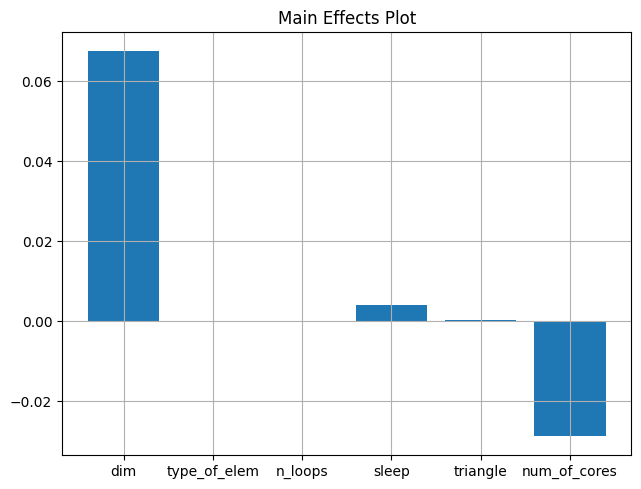

In [148]:
# Separate response and factors
response = df['exec_time']
factors = df.drop('exec_time', axis=1)

model_me = sm.OLS(response, factors)
results_me = model_me.fit()

# Create main effects plot
fig, ax = plt.subplots()
fig.tight_layout(pad=1.0)
ax.bar(factors.columns, results_me.params)
ax.set_title('Main Effects Plot')
ax.grid()
plt.show()

 => the higher dimension, the higher computational time. More cores in CPU -> lower computational time.

 This graph shows that prior intuitive interpretation of selected variables was correct.

### IA Plot

In [149]:
from statsmodels.graphics.factorplots import interaction_plot

[https://www.statsmodels.org/dev/generated/statsmodels.graphics.factorplots.interaction_plot.html](https://www.statsmodels.org/dev/generated/statsmodels.graphics.factorplots.interaction_plot.html)

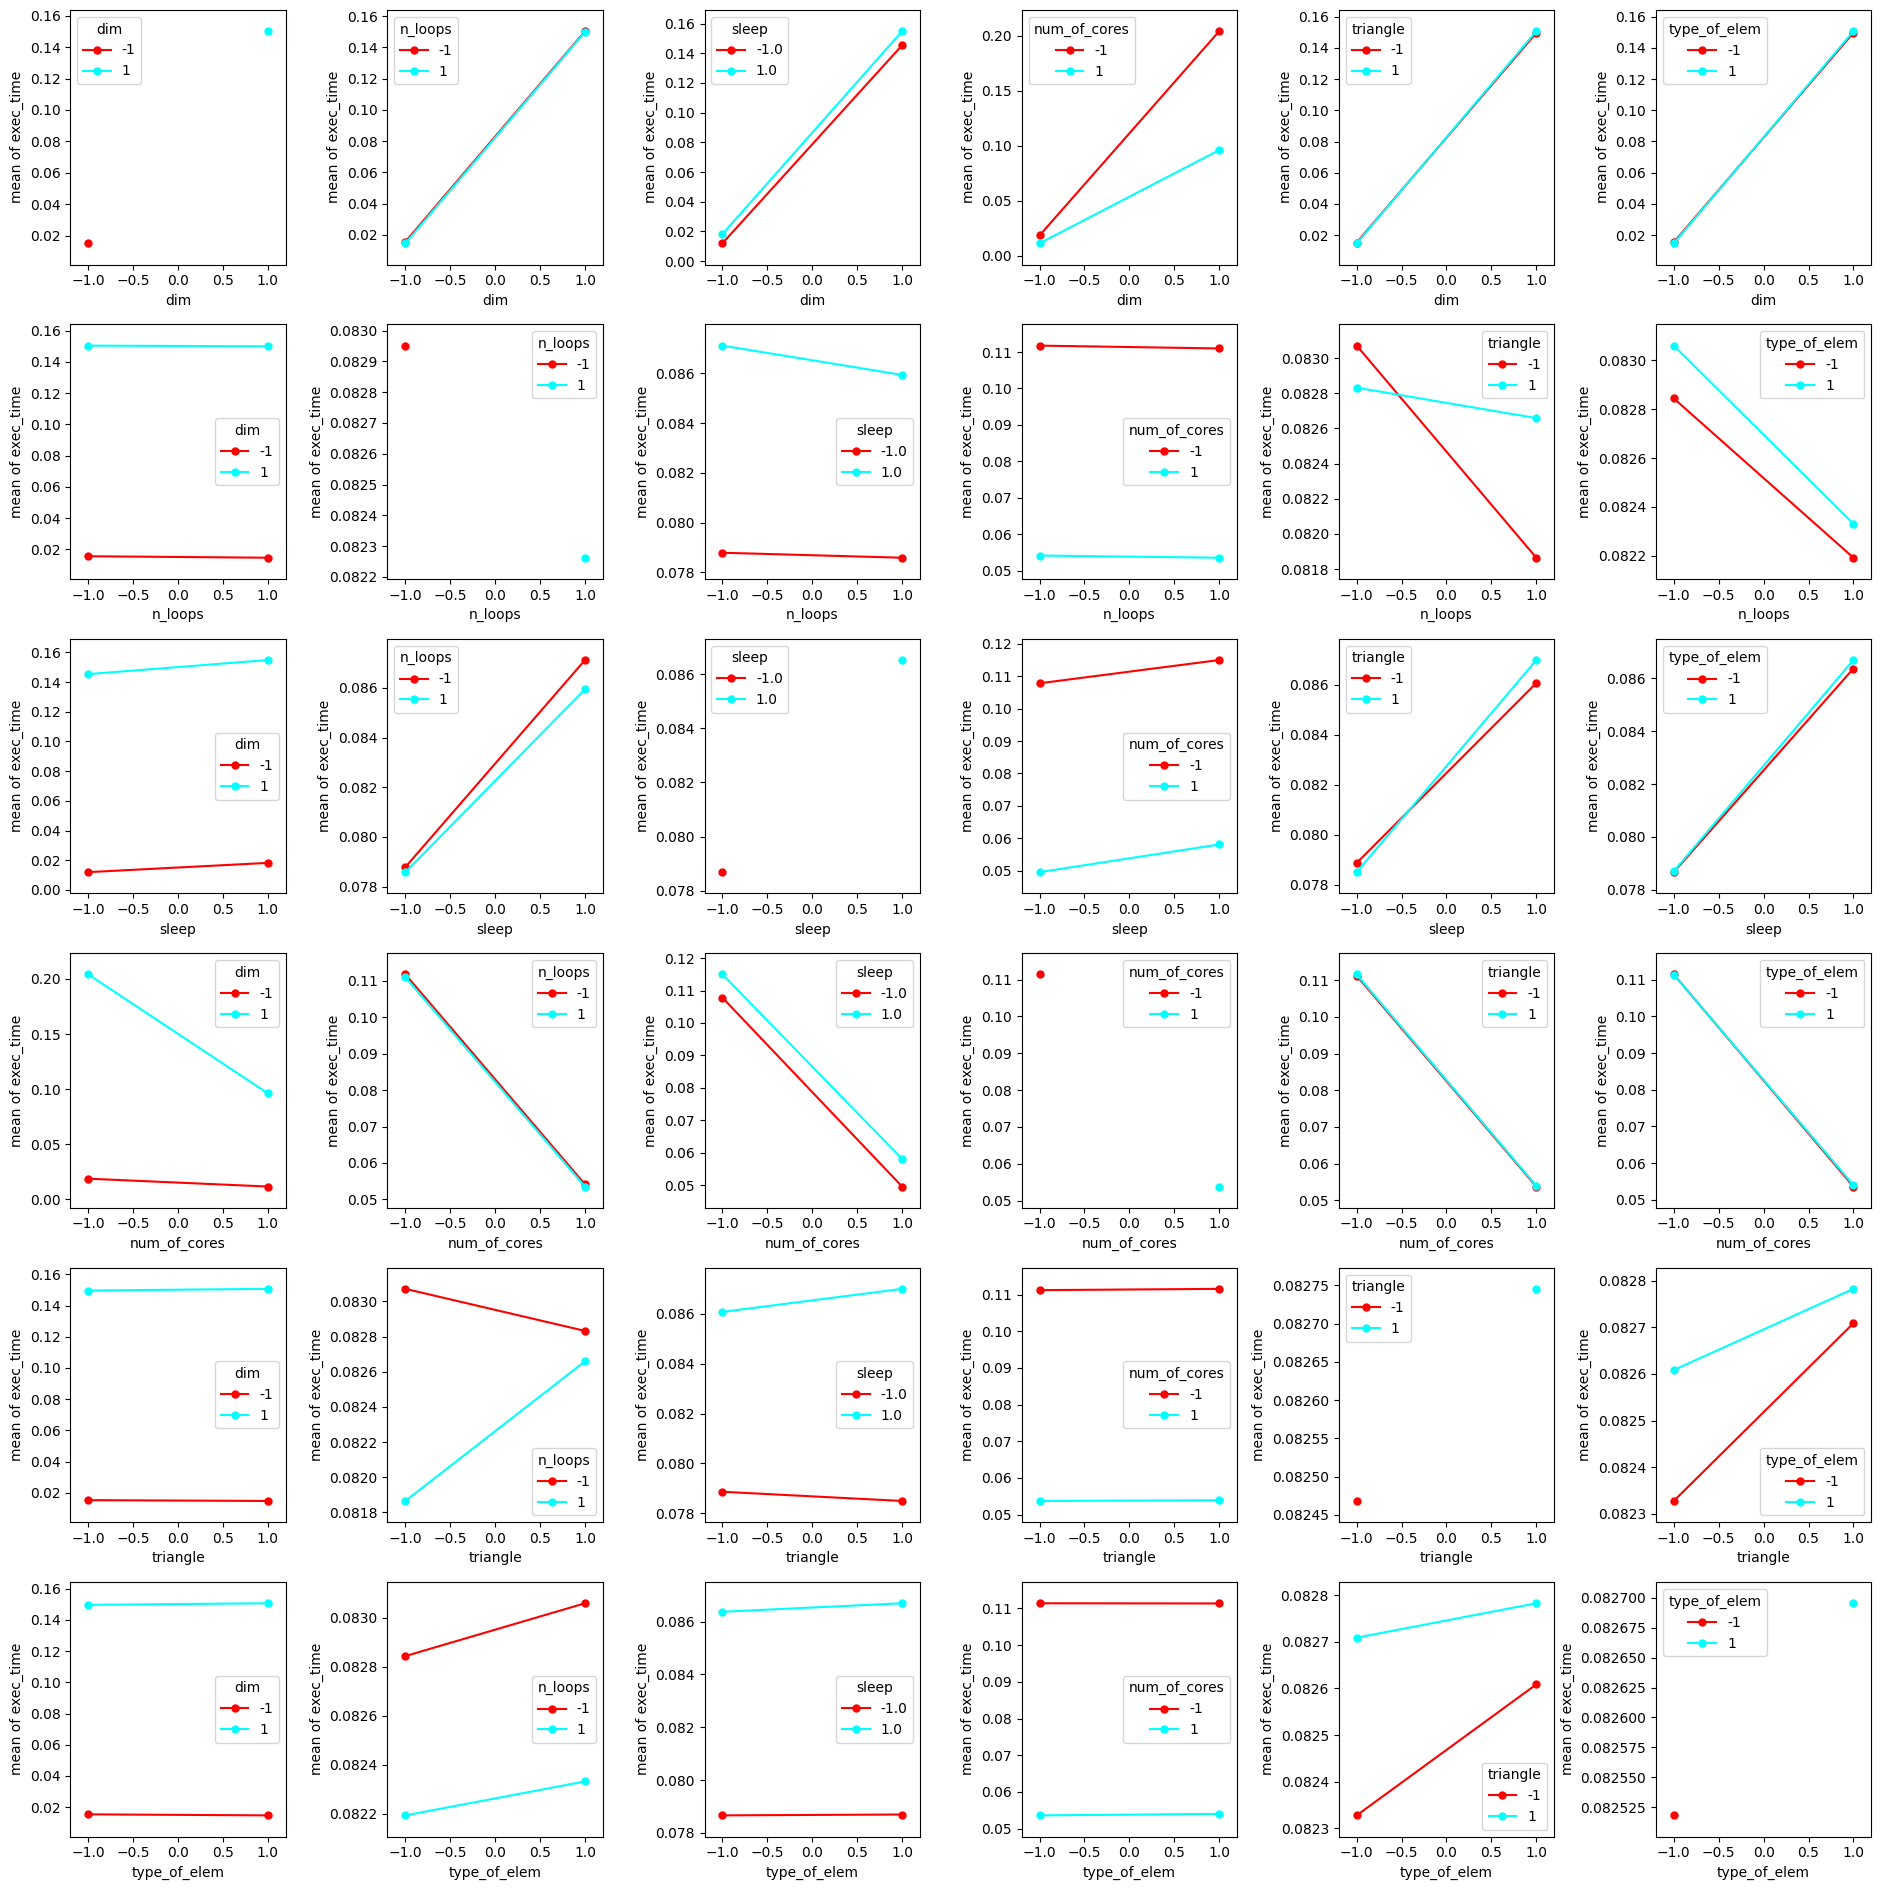

In [150]:
plt.figure(figsize=(19,19))
i = 1
for coli in [df.dim, df.n_loops, df.sleep, df.num_of_cores, df.triangle , df.type_of_elem]:
    for colj in [df.dim, df.n_loops, df.sleep, df.num_of_cores, df.triangle , df.type_of_elem]:
        ax = plt.subplot(6,6,i)
        interaction_plot(x=coli, trace=colj, response=df.exec_time, ms=10, ax=ax)
        i = i + 1
plt.savefig("img/IAPlot_emu.png", dpi=400)
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

This interaction plot shows interactions between variables. On each subfigure: x-axis represents one of variables, y-axis always represents response variable (execution time). \
On most subfigures trends of lines are the same (expected).

Most unexpected subfigure(s): **5th row, 2nd column**. It tells that
 - when the computation of `det` is performed *many times in a row*, than det(triangular_mtx) **is computed faster then** det(regular_mtx)
 - when the computation of `det` is performed a *few times*, than det(triangular_mtx) **takes more time** then det(regular_mtx)


Possible explanation:
 - influenced by some hidden variable that was not taken into account
 - effect is random (for example based on some inicialization...)
 - ???


### Box Plots

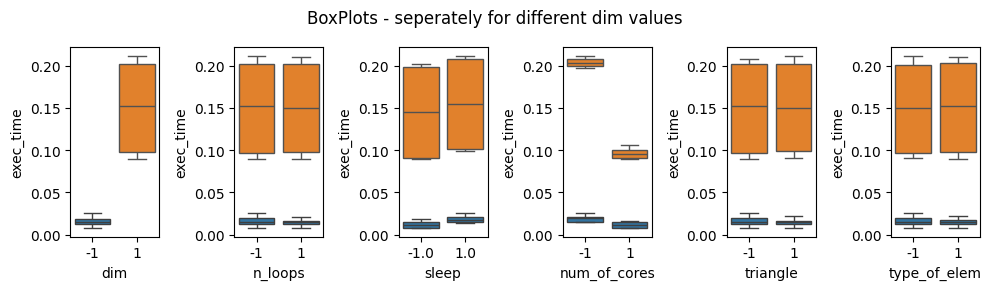

In [151]:
df_1000 = df[df['dim'] == -1]  # .... 1000
df_3000 = df[df['dim'] == 1]   # .... 3000

plt.figure(figsize=(10,5))
# 	exec_time 	dim 	n_loops 	sleep 	num_of_cores 	triangle_int 	type_int
plt.subplot(261)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.dim)
plt.subplot(262)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.n_loops)
plt.subplot(263)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.sleep)
plt.subplot(264)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.num_of_cores)
plt.subplot(265)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.triangle)
plt.subplot(266)
sbn.boxplot( y=df_1000.exec_time, x=df_1000.type_of_elem)

plt.subplot(261)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.dim)
plt.subplot(262)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.n_loops)
plt.subplot(263)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.sleep)
plt.subplot(264)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.num_of_cores)
plt.subplot(265)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.triangle)
plt.subplot(266)
sbn.boxplot( y=df_3000.exec_time, x=df_3000.type_of_elem)

plt.suptitle("BoxPlots - seperately for different dim values")
plt.tight_layout()
plt.savefig('img/boxplots_dims_seperately.png', dpi=400)
plt.show()

<ipython-input-152-e079d014ff25>:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sbn.boxplot(y=df.exec_time, x=df[column], hue=df[column_for_boxplot_rows], palette=custom_palette)
<ipython-input-152-e079d014ff25>:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sbn.boxplot(y=df.exec_time, x=df[column], hue=df[column_for_boxplot_rows], palette=custom_palette)
<ipython-input-152-e079d014ff25>:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sbn.boxplot(y=df.exec_time, x=df[column], hue=df[column_for_boxplot_rows], palette=custom_palette)
<ipython-input-152-e079d014ff25>:15: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sbn.boxplot(y=df.exec_time, x=df[column], hue=df[column_for_boxplot_rows], palette=custom_palette)
<ipython-input-152-e079d014ff25>:15: UserWarning: The palette list h

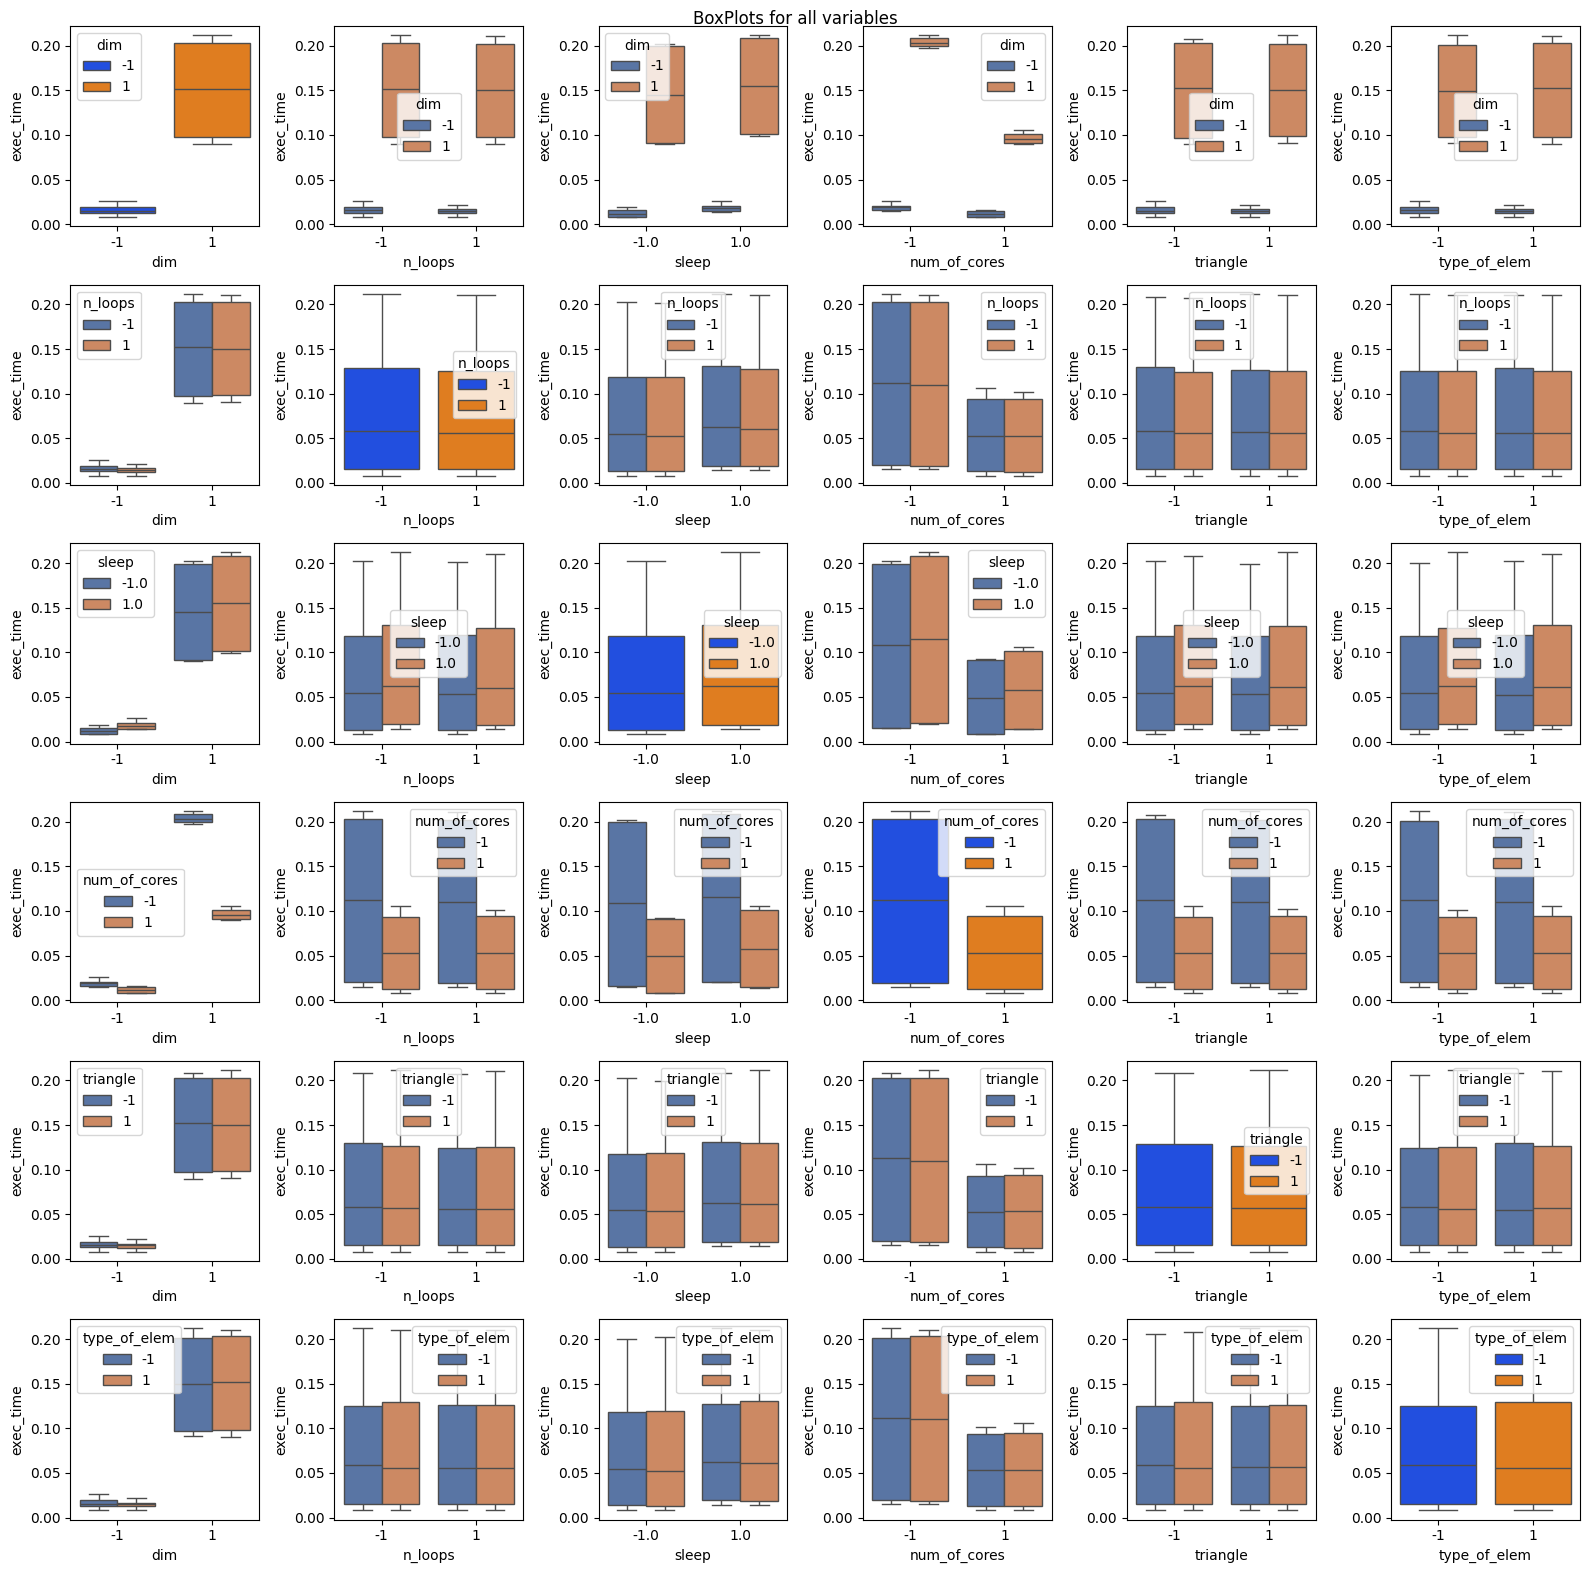

In [152]:
plt.figure(figsize=(16, 16))

# Define the columns to create subplots for
columns = ['dim', 'n_loops', 'sleep', 'num_of_cores', 'triangle', 'type_of_elem']
j = 0
# Loop through the columns and create subplots
for i , column_for_boxplot_rows in enumerate(columns, start=1):
    for _ , column in enumerate(columns, start=1):
        #print(f'i+j = {i}+{j} = {i+j}')
        plt.subplot(6, 6, i+j)
        if i+j in {1, 8, 15, 22, 29, 36}:
            custom_palette = sbn.color_palette("bright")
        else:
            custom_palette = sbn.color_palette("deep")
        sbn.boxplot(y=df.exec_time, x=df[column], hue=df[column_for_boxplot_rows], palette=custom_palette)
        j = j+1
    j = j-1

# Add common title for all subplots
plt.suptitle("BoxPlots for all variables")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save and show the plot
plt.savefig('img/boxplots_all_conditioned.png', dpi=400)
plt.show()

Boxplots are OK: it seems `dim` and `num_of_cores` are very significant factors \.
Other factors have **promising tendency** (follow median lines), but the errors are too high (it would not be possible to differentiate).

## Perform an analysis of variance and find a valid model for the experiment.

### Model of order 3:
all up to 3nd order interactions:

In [153]:
# Fit the model of ORDER 3 (one more time)
formula_3 = 'exec_time ~ ( dim + C(triangle,Sum) + C(type_of_elem, Sum) + n_loops + sleep + num_of_cores)**3'

model_3 = ols(formula_3, data=df)
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     4280.
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           8.18e-36
Time:                        23:53:35   Log-Likelihood:                 360.17
No. Observations:                  64   AIC:                            -636.3
Df Residuals:                      22   BIC:                            -545.7
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [154]:
# Print the ANOVA table
sm.stats.anova_lm(results_3, typ=2)

,sum_sq,df,F,PR(>F)
"C(triangle, Sum)",1.231411e-06,1.0,0.558835,4.626464e-01
"C(type_of_elem, Sum)",5.024658e-07,1.0,0.228027,6.377004e-01
"C(triangle, Sum):C(type_of_elem, Sum)",1.713581e-07,1.0,0.077765,7.829537e-01
dim,2.918266e-01,1.0,132435.770563,4.462990e-43
"dim:C(triangle, Sum)",1.007659e-05,1.0,4.572924,4.383613e-02
"dim:C(type_of_elem, Sum)",1.100169e-05,1.0,4.992749,3.593403e-02
"dim:C(triangle, Sum):C(type_of_elem, Sum)",5.639949e-06,1.0,2.559502,1.238968e-01
n_loops,7.605393e-06,1.0,3.451454,7.663151e-02
"C(triangle, Sum):n_loops",4.267807e-06,1.0,1.936802,1.779286e-01
"C(type_of_elem, Sum):n_loops",2.380436e-08,1.0,0.010803,9.181614e-01


I will consider every line that has p-value smaller than 0.08, i.e smaller than 8e-02.

In [155]:
alpha = 8e-02

In [156]:
anova_table_3 = sm.stats.anova_lm(results_3, typ=2)
anova_table_3.columns
anova_table_3['PR(>F)'] = anova_table_3['PR(>F)'].astype(np.float64)

In [157]:
anova_table_3 = anova_table_3[anova_table_3['PR(>F)'] < alpha]
anova_table_3

,sum_sq,df,F,PR(>F)
dim,0.291827,1.0,132435.770563,4.462990e-43
"dim:C(triangle, Sum)",0.000010,1.0,4.572924,4.383613e-02
"dim:C(type_of_elem, Sum)",0.000011,1.0,4.992749,3.593403e-02
n_loops,0.000008,1.0,3.451454,7.663151e-02
sleep,0.000986,1.0,447.262290,4.134407e-16
num_of_cores,0.053009,1.0,24056.301008,6.233651e-35
dim:sleep,0.000042,1.0,18.918119,2.569167e-04
"dim:C(triangle, Sum):sleep",0.000009,1.0,4.288469,5.030559e-02
dim:num_of_cores,0.040664,1.0,18453.908564,1.148201e-33
"C(triangle, Sum):sleep:num_of_cores",0.000015,1.0,6.741121,1.647758e-02


**Remark:**
Alpha level $\alpha=8 \cdot 10^{-2} = 0.08 $ was chosen empirically. \


### Reduced model:

 - since ANOVA showed several interactions as significant, all variables that appear in interactions are also included by themselves
 - interactions are inlcuded based on ANOVA results above
 - interaction of 3rd order was excluded due to unknown interpretation

In [158]:
formula_chosen = 'exec_time ~ dim + sleep + n_loops + C(type_of_elem, Sum) + num_of_cores + C(triangle, Sum) + \
+ dim:C(triangle, Sum) + dim:C(type_of_elem, Sum) + dim:sleep + dim:num_of_cores'

model_chosen = ols(formula_chosen, data=df)
results_chosen = model_chosen.fit()
print(results_chosen.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.674e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           5.35e-89
Time:                        23:53:36   Log-Likelihood:                 330.54
No. Observations:                  64   AIC:                            -639.1
Df Residuals:                      53   BIC:                            -615.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### ANOVA table of reduced model:

In [159]:
sm.stats.anova_lm(results_chosen, typ=2)

,sum_sq,df,F,PR(>F)
"C(type_of_elem, Sum)",5.024658e-07,1.0,0.217577,6.428038e-01
"C(triangle, Sum)",1.231411e-06,1.0,0.533224,4.684700e-01
dim,2.918266e-01,1.0,126366.483997,3.412563e-91
"dim:C(triangle, Sum)",1.007659e-05,1.0,4.363355,4.153820e-02
"dim:C(type_of_elem, Sum)",1.100169e-05,1.0,4.763940,3.351385e-02
sleep,9.855573e-04,1.0,426.765086,5.107987e-27
n_loops,7.605393e-06,1.0,3.293280,7.522480e-02
num_of_cores,5.300886e-02,1.0,22953.845199,1.387824e-71
dim:sleep,4.168670e-05,1.0,18.051136,8.733704e-05
dim:num_of_cores,4.066380e-02,1.0,17608.200045,1.533407e-68


As we see, variables `type_of_elem` and `triangle` are not as significant, but we will try to keep them since their interactions with other variables are significant.

At this point, we have build&chosen a model using dataset where each variable has only two possible values.

## 6. Adding center points.

Considered center points at following values:

 - `dim` (added dim = 2000: between 1000 and 3000)
 - `num_of_cores` (added num_of_cores = 4: not between 2 and 8, but close)
 - `sleep` (added sleep = 0.25 sek: between 0 and 0.5 sek)
 - `n_loops` (added sleep = 505: between 1000 and 1000 sek)

How centerpoints were measured:
categorical variables were fixed on low value.

In [160]:
file_path = 'https://raw.githubusercontent.com/aleksejalex/DetermiTime/main/df_emu_cp_preprocessed.csv'
try:
    df_cp_only = pd.read_csv(file_path, delimiter=';')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print(f"File not found at path: {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame loaded successfully.


In [161]:
df_cp = pd.concat([df, df_cp_only], ignore_index=True)  # concatenate both my previous 64 observations and my new 4 centerpoints

In [162]:
# explicit derinition of cathegorical vars
df_cp['dim']          = df_cp['dim'].astype('int64')
df_cp['type_of_elem'] = df_cp['type_of_elem'].astype('category')
df_cp['n_loops']      = df_cp['n_loops'].astype('int64')
df_cp['sleep']        = df_cp['sleep'].astype('int64')
df_cp['triangle']     = df_cp['triangle'].astype('category')
df_cp['num_of_cores'] = df_cp['num_of_cores'].astype('int64')

In [163]:
#df_cp

In [164]:
# shuffle df_cp:
df_cp = df_cp.sample(frac=1).reset_index(drop=True)

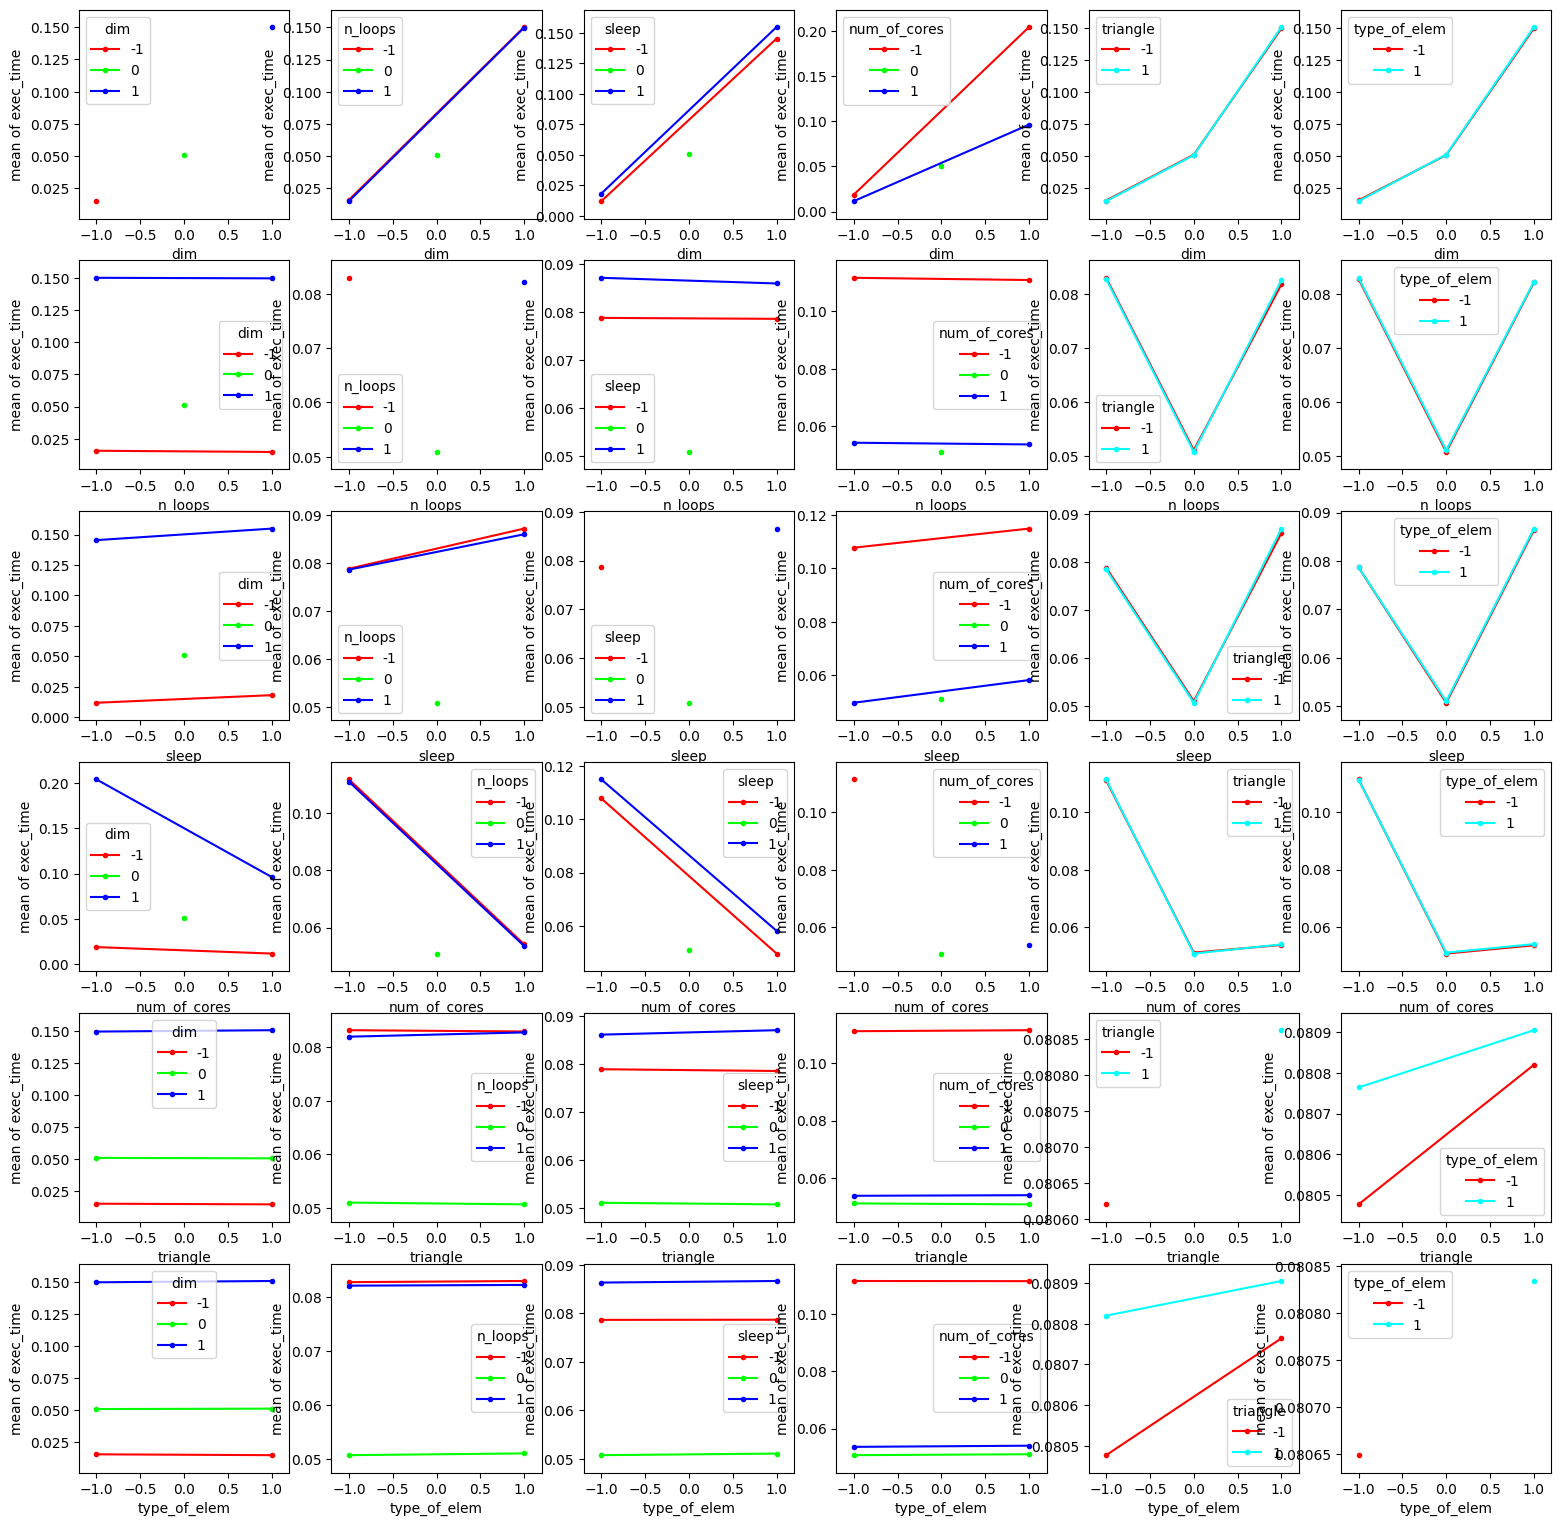

In [165]:
plt.figure(figsize=(19,19))
plt.tight_layout(pad=1.0)
i = 1
for coli in [df_cp.dim, df_cp.n_loops, df_cp.sleep, df_cp.num_of_cores, df_cp.triangle , df_cp.type_of_elem]:
    for colj in [df_cp.dim, df_cp.n_loops, df_cp.sleep, df_cp.num_of_cores, df_cp.triangle , df_cp.type_of_elem]:
        ax = plt.subplot(6,6,i)
        interaction_plot(x=coli, trace=colj, response=df_cp.exec_time, ax=ax)
        i = i + 1
plt.savefig("img/IAPlot_new_data_cp.png", dpi=400)
plt.show()

### Model of order 3 on centerpoints:

In [166]:
# Fit the model of ORDER 3 (one more time)
formula_3 = 'exec_time ~ ( C(dim, Sum) + C(triangle, Sum) + C(type_of_elem, Sum) + C(n_loops, Sum) + C(sleep, Sum) + C(num_of_cores, Sum))**3'

model_3_cp = ols(formula_3, data=df_cp)
results_3_cp = model_3_cp.fit()
print(results_3_cp.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     3937.
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           1.71e-35
Time:                        23:53:50   Log-Likelihood:                 384.75
No. Observations:                  68   AIC:                            -677.5
Df Residuals:                      22   BIC:                            -575.4
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

ANOVA table for level $\alpha$:  

In [167]:
anova_table_3_cp = sm.stats.anova_lm(results_3_cp, typ=2)
anova_table_3_cp

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/l

,sum_sq,df,F,PR(>F)
"C(dim, Sum)",1.334788e-15,2.0,3.028744e-10,1.000000e+00
"C(triangle, Sum)",-1.593727e-18,1.0,-7.232599e-13,1.000000e+00
"C(type_of_elem, Sum)",4.856001e-17,1.0,2.203734e-11,9.999963e-01
"C(n_loops, Sum)",8.222362e-16,2.0,1.865722e-10,1.000000e+00
"C(sleep, Sum)",1.137863e-15,2.0,2.581906e-10,1.000000e+00
"C(num_of_cores, Sum)",-3.160190e-18,2.0,-7.170735e-13,1.000000e+00
"C(dim, Sum):C(triangle, Sum)",1.196562e-05,2.0,2.715099e+00,1.136127e-01
"C(dim, Sum):C(type_of_elem, Sum)",1.763107e-06,2.0,4.000636e-01,6.750555e-01
"C(dim, Sum):C(n_loops, Sum)",9.301603e-01,4.0,1.055306e+05,1.576382e-44
"C(dim, Sum):C(sleep, Sum)",4.664947e-01,4.0,5.292576e+04,1.829343e-43


Here is trimmed anova table:

In [168]:
anova_table_3_cp['PR(>F)'] = anova_table_3_cp['PR(>F)'].astype(np.float64)
anova_table_3_cp = anova_table_3_cp[anova_table_3_cp['PR(>F)'] < alpha]
anova_table_3_cp

,sum_sq,df,F,PR(>F)
"C(dim, Sum):C(n_loops, Sum)",0.930160,4.0,105530.550627,1.576382e-44
"C(dim, Sum):C(sleep, Sum)",0.466495,4.0,52925.757594,1.829343e-43
"C(dim, Sum):C(num_of_cores, Sum)",0.608358,4.0,69020.783476,7.525430e-44
"C(n_loops, Sum):C(sleep, Sum)",0.646374,4.0,73333.863976,3.863589e-44
"C(n_loops, Sum):C(num_of_cores, Sum)",0.440135,4.0,49935.168301,3.468400e-43
"C(sleep, Sum):C(num_of_cores, Sum)",0.901028,4.0,102225.361258,2.236971e-44
"C(dim, Sum):C(triangle, Sum):C(sleep, Sum)",0.000028,4.0,3.210653,3.214464e-02
"C(dim, Sum):C(n_loops, Sum):C(sleep, Sum)",0.222662,8.0,12630.957466,1.890872e-38
"C(dim, Sum):C(n_loops, Sum):C(num_of_cores, Sum)",0.353489,8.0,20052.410030,1.172492e-40
"C(dim, Sum):C(sleep, Sum):C(num_of_cores, Sum)",0.346871,8.0,19676.978917,1.443391e-40


## Model based on dataset WITH CENTERPOINTS:
contains all variables contained in following interactions and the interactions themselves:
 - `dim`:`n_loops`
 - `dim`:`sleep`
 - `dim`:`num_of_cores`
 - `n_loops`:`sleep`
 - `sleep`:`num_of_cores`

The rest of "recommended" interactions were excluded due to high order (3) and unknown interpretation.
Also variable `type_of_elem` was excluded since it appears as insignificant.

In [169]:
# Model based on dataset WITH CENTERPOINTS
formula_chosen_cp = 'exec_time ~ C(dim, Sum) + C(triangle, Sum) + C(n_loops, Sum) + C(sleep, Sum) + C(num_of_cores, Sum) + \
C(dim, Sum):C(n_loops, Sum) + C(dim, Sum):C(sleep, Sum) + C(dim, Sum):C(num_of_cores, Sum) + C(n_loops, Sum):C(sleep, Sum) + C(sleep, Sum):C(num_of_cores, Sum)'

#formula_chosen_cp = 'exec_time ~ C(dim, Sum):C(n_loops, Sum) + C(dim, Sum):C(sleep, Sum) + C(dim, Sum):C(num_of_cores, Sum) + C(n_loops, Sum):C(sleep, Sum) + C(sleep, Sum):C(num_of_cores, Sum)'

model_chosen_cp = ols(formula_chosen_cp, data=df_cp)
results_chosen_cp = model_chosen_cp.fit()
print(results_chosen_cp.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.504e+04
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           6.25e-93
Time:                        23:53:50   Log-Likelihood:                 350.66
No. Observations:                  68   AIC:                            -677.3
Df Residuals:                      56   BIC:                            -650.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### Conclusion to centerpoints:



Center points helped to develop a better model.

## 7. Model diagnostics.

### ANOVA table of model suggested using centerpoints:

In [170]:
anova_table_chosen_cp = sm.stats.anova_lm(results_chosen_cp, typ=2)
anova_table_chosen_cp

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
"C(dim, Sum)",4.084903e-01,2.0,86576.253988,1.859202e-98
"C(triangle, Sum)",9.919142e-07,1.0,0.420457,5.193595e-01
"C(n_loops, Sum)",4.957807e-01,2.0,105076.755359,8.222401e-101
"C(sleep, Sum)",4.105651e-01,2.0,87016.003334,1.613381e-98
"C(num_of_cores, Sum)",7.714012e-01,2.0,163492.337502,9.843559e-99
"C(dim, Sum):C(n_loops, Sum)",2.885153e-01,4.0,30574.262865,9.083563e-93
"C(dim, Sum):C(sleep, Sum)",2.809314e-01,4.0,29770.580548,1.914363e-92
"C(dim, Sum):C(num_of_cores, Sum)",3.916787e-01,4.0,41506.586249,1.747689e-96
"C(n_loops, Sum):C(sleep, Sum)",7.395629e-02,4.0,7837.222750,3.126009e-76
"C(sleep, Sum):C(num_of_cores, Sum)",1.326564e-01,4.0,14057.737884,2.510897e-83


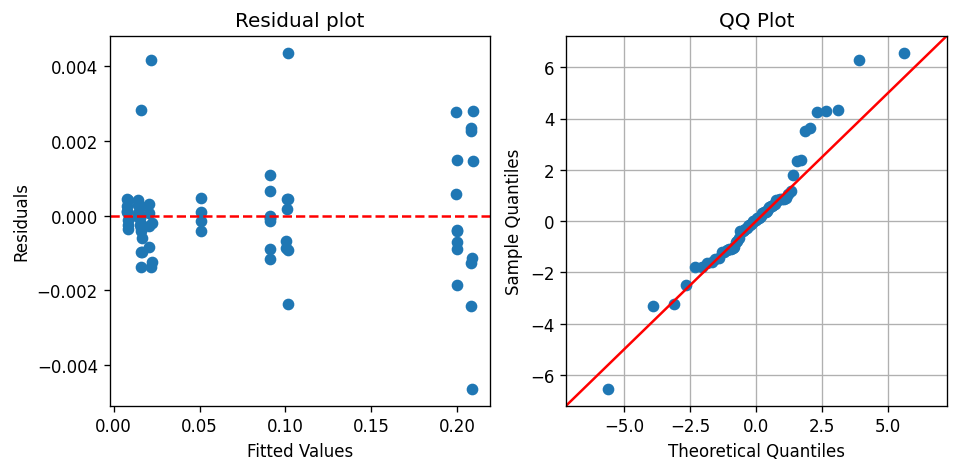

In [171]:
from scipy import stats
plt.figure(figsize=(9,4), dpi=120)
plt.subplot(1,2,1)
plt.scatter(results_chosen_cp.fittedvalues, results_chosen_cp.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title("Residual plot")
plt.axhline(y=0, color='r', linestyle='--')
ax = plt.subplot(1,2,2)
sm.qqplot(results_chosen_cp.resid, scp.stats.t, fit=True, line='45', ax=ax)
plt.title('QQ Plot')
plt.grid()

plt.savefig("img/residuals_of_OLS_cp.png", dpi=400)
plt.show()

In [172]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
# https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html
# https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test
# testuje lin. zavislost rozptylu rezidui na datech
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(results_chosen_cp.resid, results_chosen_cp.model.exog)

# Print the results
print("Breusch-Pagan Test:")
print("LM Statistic:", lm)
print("LM p-value:", lm_p_value)

# Interpret the p-value
alpha = 0.05
if lm_p_value > alpha:
    print("The residuals are homoscedastic (fail to reject H0, have to accept H0)")
else:
    print("The residuals are heteroscedastic (reject H0)")

Breusch-Pagan Test:
LM Statistic: 25.104913721889766
LM p-value: 0.6727919896258061
The residuals are homoscedastic (fail to reject H0, have to accept H0)


In [173]:
# Normality of residuals - Shapiro-Wilk test
#  (can be important especially in case of small sample size)
print(f"H0: sample (residuals) came from normal distribution.")
from scipy.stats import shapiro
stat, p_value = shapiro(results_chosen_cp.resid)
print(f'Shapiro-Wilk Test: Statistic={stat}, p-value={p_value}')

alpha = 0.01  # significance level
if p_value < alpha:
    print("Reject H_0 (Have to accept H_1). ")
else:
    print("Can't reject H_0 (Have to accept H_0). ")

H0: sample (residuals) came from normal distribution.
Shapiro-Wilk Test: Statistic=0.9015474319458008, p-value=5.657146903104149e-05
Reject H_0 (Have to accept H_1). 


In [174]:
# VIF
# =is a measure that quantifies the extent of multicollinearity in a set of predictor variables within a regression model.
# Multicollinearity occurs when two or more independent variables in a model are highly correlated,
# making it difficult to isolate the individual effect of each variable on the dependent variable.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = df_cp.columns
vif["VIF"] = [variance_inflation_factor(df_cp.values, i) for i in range(df_cp.shape[1])]
#print(vif)
vif

,Variable,VIF
0,exec_time,1.708758
1,dim,1.598081
2,type_of_elem,1.000001
3,n_loops,1.000016
4,sleep,1.002020
5,triangle,1.000002
6,num_of_cores,1.108638


## Countour plot for two chosen numerical variables.

In [175]:
# Model based on dataset WITH CENTERPOINTS
formula_8 = 'exec_time ~ dim + triangle + n_loops + sleep + num_of_cores + \
dim:n_loops + dim:sleep + dim:num_of_cores + n_loops:sleep + sleep:num_of_cores'
#formula_chosen_cp = 'exec_time ~ C(dim, Sum):C(n_loops, Sum) + C(dim, Sum):C(sleep, Sum) + C(dim, Sum):C(num_of_cores, Sum) + C(n_loops, Sum):C(sleep, Sum) + C(sleep, Sum):C(num_of_cores, Sum)'

model_8= ols(formula_8, data=df_cp)
results_8 = model_8.fit()
#results_8.summary()

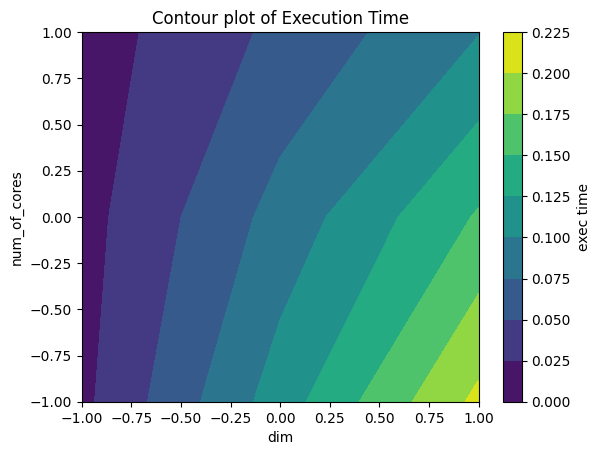

In [176]:
levels = [-1,0,1]
# Fit the OLS model
formula_8 = 'exec_time ~ dim + triangle + n_loops + sleep + num_of_cores + \
dim:n_loops + dim:sleep + dim:num_of_cores + n_loops:sleep + sleep:num_of_cores'

model_8 = sm.formula.ols(formula_8, data=df_cp)
results_8 = model_8.fit()

# Create grid for contour plot
dim_range = levels
num_of_cores_range = levels

dim_grid, n_loops_grid = np.meshgrid(dim_range, num_of_cores_range)

# Create DataFrame for prediction
predict_df = pd.DataFrame({'dim': dim_grid.ravel(), 'num_of_cores': n_loops_grid.ravel()})
predict_df['triangle'] = 1  # Assuming 'triangle' is constant
predict_df['sleep'] = 1  # Assuming 'sleep' is constant
predict_df['n_loops'] = 1  # Assuming 'num_of_cores' is constant

# Predict using the model
predictions = results_8.predict(predict_df)

# Reshape predictions to match grid shape
predictions_grid = np.array(predictions).reshape(dim_grid.shape)

# Plot the contour plot
plt.contourf(dim_grid, n_loops_grid, predictions_grid, cmap='viridis')
plt.colorbar(label='exec time')
plt.xlabel('dim')
plt.ylabel('num_of_cores')
plt.title('Contour plot of Execution Time')
plt.show()


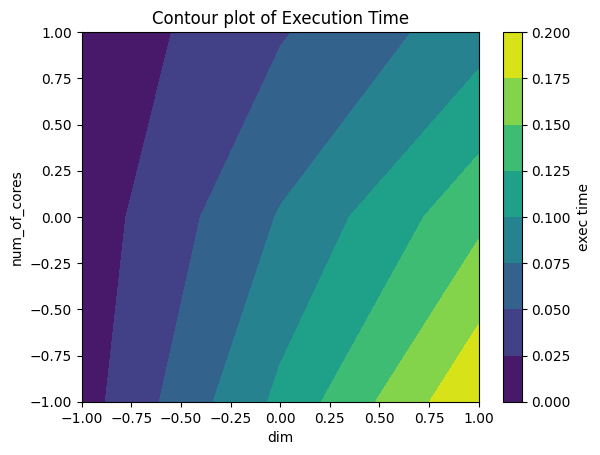

In [177]:
predict_df = pd.DataFrame({'dim': dim_grid.ravel(), 'num_of_cores': n_loops_grid.ravel()})
predict_df['triangle'] = -1  # Assuming 'triangle' is constant
predict_df['sleep'] = -1  # Assuming 'sleep' is constant
predict_df['n_loops'] = -1  # Assuming 'num_of_cores' is constant

# Predict using the model
predictions = results_8.predict(predict_df)

# Reshape predictions to match grid shape
predictions_grid = np.array(predictions).reshape(dim_grid.shape)

# Plot the contour plot
plt.contourf(dim_grid, n_loops_grid, predictions_grid, cmap='viridis')
plt.colorbar(label='exec time')
plt.xlabel('dim')
plt.ylabel('num_of_cores')
plt.title('Contour plot of Execution Time')
plt.show()

# END.

In [178]:
print("""
explanation of 'C(.)' inside formula:

    C(x_1): This indicates that x_1 is a categorical variable. When you use C()
    around a variable, statsmodels treats it as categorical, meaning it will
    create dummy variables for each category. For example, if x_1 has three
    categories (let's say 'A', 'B', and 'C'), C(x_1) will create two dummy
    variables (for 'B' and 'C') to represent the categories 'B' and 'C',
    respectively, while 'A' becomes the reference category.

    C(x_2, sum): The , sum part specifies how to handle multiple categories.
    By default, statsmodels uses treatment coding, where one category is treated
    as a reference and the other categories are compared to it. However, sum
    specifies that you want to use sum-to-zero contrasts. In this contrast coding,
    the sum of the coefficients for the dummy variables corresponding to each
    category is set to zero. This can be useful for certain types of analyses,
    especially when you want to interpret the coefficients relative to the
    overall mean.

""")


explanation of 'C(.)' inside formula:

    C(x_1): This indicates that x_1 is a categorical variable. When you use C()
    around a variable, statsmodels treats it as categorical, meaning it will
    create dummy variables for each category. For example, if x_1 has three
    categories (let's say 'A', 'B', and 'C'), C(x_1) will create two dummy
    variables (for 'B' and 'C') to represent the categories 'B' and 'C',
    respectively, while 'A' becomes the reference category.

    C(x_2, sum): The , sum part specifies how to handle multiple categories.
    By default, statsmodels uses treatment coding, where one category is treated
    as a reference and the other categories are compared to it. However, sum
    specifies that you want to use sum-to-zero contrasts. In this contrast coding,
    the sum of the coefficients for the dummy variables corresponding to each
    category is set to zero. This can be useful for certain types of analyses,
    especially when you want to interpret t

In [179]:
# Fit a linear model
X = sm.add_constant(df_cp[['dim', 'num_of_cores']])
model8 = sm.OLS(df_cp['exec_time'], X).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:              exec_time   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     245.6
Date:                Tue, 12 Mar 2024   Prob (F-statistic):           5.00e-31
Time:                        23:53:53   Log-Likelihood:                 151.94
No. Observations:                  68   AIC:                            -297.9
Df Residuals:                      65   BIC:                            -291.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0807      0.003     25.129   

-0.5 1.5 -0.9 1.1


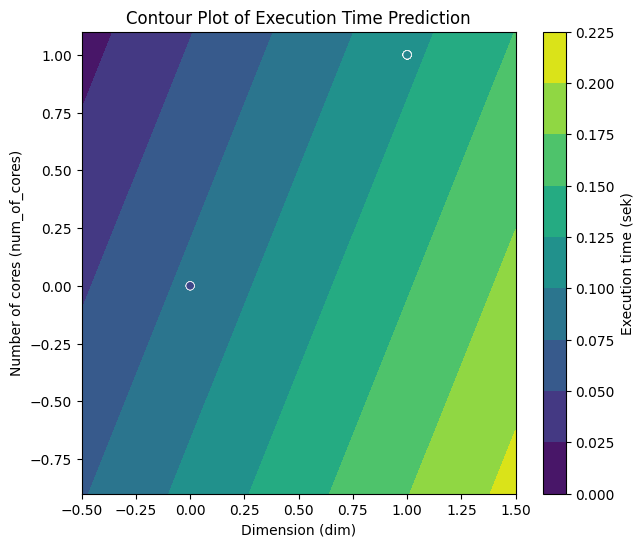

In [180]:
dim_min = df_cp['dim'].min() - 0.5 * df_cp['dim'].min()
dim_max = df_cp['dim'].max() + 0.5 * df_cp['dim'].max()
cores_min = df_cp['num_of_cores'].min() - 0.1 * df_cp['num_of_cores'].min()
cores_max = df_cp['num_of_cores'].max() + 0.1 * df_cp['num_of_cores'].max()
print(f"{dim_min} {dim_max} {cores_min} {cores_max}")
dim_range = np.linspace(dim_min, dim_max, 100)
num_of_cores_range = np.linspace(cores_min, cores_max, 100)

dim_grid, num_of_cores_grid = np.meshgrid(dim_range, num_of_cores_range)
design_matrix = pd.DataFrame({'dim': dim_grid.flatten(), 'num_of_cores': num_of_cores_grid.flatten()})
design_matrix_const = sm.add_constant(design_matrix)

# Predict the exec_time for each combination of dim and num_of_cores
#predictions = results_chosen_cp.predict(design_matrix_const)
predictions = model8.predict(design_matrix_const)

# Reshape the predictions to match the shape of the grids
predictions = predictions.values.reshape(dim_grid.shape)

# Create the contour plot
plt.figure(figsize=(7, 6))
contour = plt.contourf(dim_grid, num_of_cores_grid, predictions, cmap='viridis')

# Scatter plot for data points
sbn.scatterplot(data=df_cp, x='dim', y='num_of_cores', hue='exec_time', palette='viridis', marker='o', legend=False)

plt.colorbar(contour, label='Execution time (sek)')
plt.xlim(dim_min, dim_max)
plt.ylim(cores_min, cores_max)
plt.xlabel('Dimension (dim)')
plt.ylabel('Number of cores (num_of_cores)')
plt.title('Contour Plot of Execution Time Prediction')
plt.show()

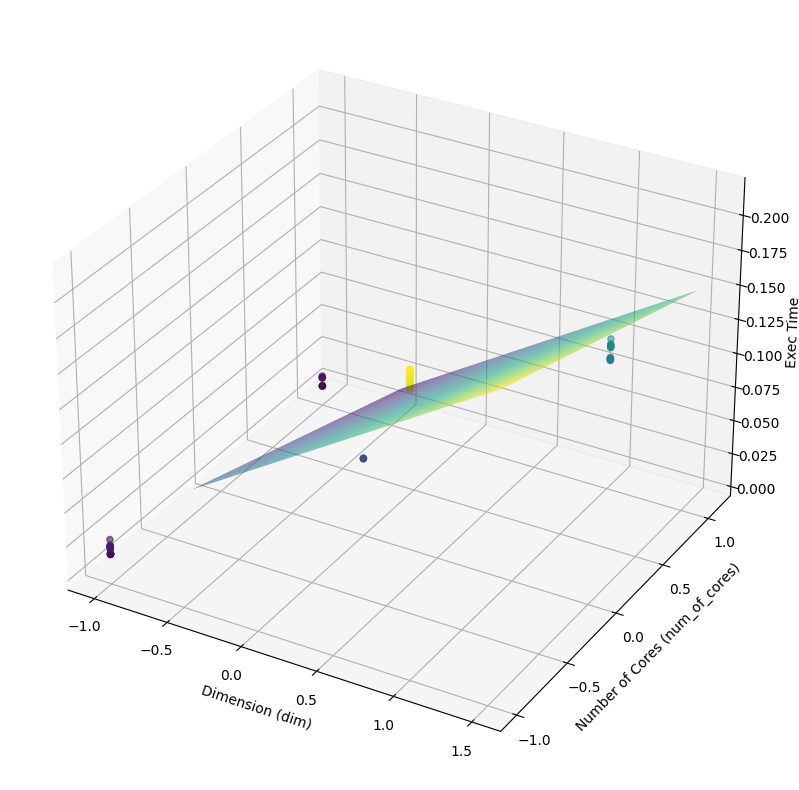

In [181]:
# Plot the hyperplane
# Create the 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for data points
ax.scatter(df_cp['dim'], df_cp['num_of_cores'], df_cp['exec_time'], c=df_cp['exec_time'], cmap='viridis', marker='o')

ax.plot_surface(dim_grid, num_of_cores_grid, predictions, alpha=0.7, cmap='viridis')

# Set labels and title
ax.set_xlabel('Dimension (dim)')
ax.set_ylabel('Number of Cores (num_of_cores)')
ax.set_zlabel('Exec Time')

# Show the plot
plt.show()